# Stonks 

Use tensorflow to build deep learning based time series forcasting models based on financial data.

Try out different neural network architectures, see which one works best for this task.

Keep track of the performance of all of the models.

Read the official Tensorflow time series forecasting [guide](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yfinance as yf

mpl.rcParams['figure.figsize'] = (16, 9)

### Dataset

Currently using `yfinance` to access yahoo finance historical data since it is free.

In [2]:
tickers = ['SPY', 'AAPL', 'MSFT', 'TSLA', 'TQQQ', 'MS', 'GS', 'AMZN', 'NFLX', 'GOOG', 'XLF', 'WMT', 'GE', 'VZ']

In [3]:
def create_yfinance_df(tickers):
    return yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = tickers,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = 'max',

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = '1d',

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )


In [4]:
multi_index_column_ticker_df = create_yfinance_df(tickers)

[*********************100%***********************]  14 of 14 completed


What do the first few entries look like? These should be the oldest.

In [5]:
multi_index_column_ticker_df.head()

SPY                       AAPL                        ... TQQQ  \
           Open High Low Close Volume Open High Low Close Volume  ... Open   
Date                                                              ...        
1962-01-02  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...  NaN   
1962-01-03  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...  NaN   
1962-01-04  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...  NaN   
1962-01-05  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...  NaN   
1962-01-08  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...  NaN   

                                 MSFT                        
           High Low Close Volume Open High Low Close Volume  
Date                                                         
1962-01-02  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  
1962-01-03  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  
1962-01-04  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  
1962-01-05  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  
1962-01-08  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  

[5 rows x 70 columns]

What do the last few entries look like? These should be the newest.

In [6]:
multi_index_column_ticker_df.tail()

SPY                                                   \
                  Open        High         Low       Close       Volume   
Date                                                                      
2020-09-03  355.869995  356.380005  342.589996  345.390015  148011100.0   
2020-09-04  346.130005  347.829987  334.869995  342.570007  139156300.0   
2020-09-08  336.709991  342.640015  332.880005  333.209991  114465300.0   
2020-09-09  337.549988  342.459991  336.609985  339.790009   90699900.0   
2020-09-10  341.820007  342.519989  332.850006  333.890015   84635641.0   

                  AAPL                                                   ...  \
                  Open        High         Low       Close       Volume  ...   
Date                                                                     ...   
2020-09-03  126.910004  128.839996  120.500000  120.879997  257599600.0  ...   
2020-09-04  120.070000  123.699997  110.889999  120.959999  332607200.0  ...   
2020-09-08  113.949997  118.989998  112.680000  112.820000  231366600.0  ...   
2020-09-09  117.260002  119.139999  115.260002  117.320000  176276400.0  ...   
2020-09-10  120.360001  120.419998  112.500000  113.489998  177284335.0  ...   

                  TQQQ                                                  \
                  Open        High         Low       Close      Volume   
Date                                                                     
2020-09-03  166.729996  167.399994  142.820007  147.729996  55378100.0   
2020-09-04  145.380005  150.300003  123.860001  141.639999  70185100.0   
2020-09-08  124.949997  133.970001  121.059998  121.620003  53353100.0   
2020-09-09  129.029999  135.199997  125.669998  132.070007  36125500.0   
2020-09-10  136.520004  138.380005  121.739998  124.430000  57807342.0   

                  MSFT                                                  
                  Open        High         Low       Close      Volume  
Date                                                                    
2020-09-03  229.270004  229.309998  214.960007  217.300003  58400300.0  
2020-09-04  215.100006  218.360001  205.190002  214.250000  59664100.0  
2020-09-08  206.500000  210.029999  202.199997  202.660004  52924300.0  
2020-09-09  207.600006  214.839996  206.699997  211.289993  45582200.0  
2020-09-10  213.399994  214.729996  204.110001  205.369995  33722693.0  

[5 rows x 70 columns]

In [7]:
multi_index_column_ticker_df.dtypes

SPY   Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume    float64
                 ...   
MSFT  Open      float64
      High      float64
      Low       float64
      Close     float64
      Volume    float64
Length: 70, dtype: object

Is the data properly indexed by date already for me?

In [8]:
multi_index_column_ticker_df.index

DatetimeIndex(['1962-01-02', '1962-01-03', '1962-01-04', '1962-01-05',
               '1962-01-08', '1962-01-09', '1962-01-10', '1962-01-11',
               '1962-01-12', '1962-01-15',
               ...
               '2020-08-27', '2020-08-28', '2020-08-31', '2020-09-01',
               '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-08',
               '2020-09-09', '2020-09-10'],
              dtype='datetime64[ns]', name='Date', length=14777, freq=None)

Seems like it, I should be able to select date ranges

In [9]:
multi_index_column_ticker_df['2020-08-27':'2020-08-31']

SPY                                                  \
                  Open        High         Low       Close      Volume   
Date                                                                     
2020-08-27  348.510010  349.899994  346.529999  348.329987  58034100.0   
2020-08-28  349.440002  350.720001  348.149994  350.579987  48588900.0   
2020-08-31  350.350006  351.299988  349.059998  349.309998  66099200.0   

                  AAPL                                                   ...  \
                  Open        High         Low       Close       Volume  ...   
Date                                                                     ...   
2020-08-27  127.142502  127.485001  123.832497  125.010002  155552400.0  ...   
2020-08-28  126.012497  126.442497  124.577499  124.807503  187630000.0  ...   
2020-08-31  127.580002  131.000000  126.000000  129.039993  225702700.0  ...   

                  TQQQ                                                  \
                  Open        High         Low       Close      Volume   
Date                                                                     
2020-08-27  158.580002  159.869995  151.580002  155.309998  37825300.0   
2020-08-28  157.289993  158.729996  155.149994  157.710007  24768200.0   
2020-08-31  158.539993  164.539993  157.820007  161.360001  22549800.0   

                  MSFT                                                  
                  Open        High         Low       Close      Volume  
Date                                                                    
2020-08-27  222.889999  231.149994  219.399994  226.580002  57602200.0  
2020-08-28  228.179993  230.639999  226.580002  228.910004  26292900.0  
2020-08-31  227.000000  228.699997  224.309998  225.529999  28774200.0  

[3 rows x 70 columns]

In [10]:
multi_index_column_ticker_df.columns

MultiIndex([( 'SPY',   'Open'),
            ( 'SPY',   'High'),
            ( 'SPY',    'Low'),
            ( 'SPY',  'Close'),
            ( 'SPY', 'Volume'),
            ('AAPL',   'Open'),
            ('AAPL',   'High'),
            ('AAPL',    'Low'),
            ('AAPL',  'Close'),
            ('AAPL', 'Volume'),
            ('TSLA',   'Open'),
            ('TSLA',   'High'),
            ('TSLA',    'Low'),
            ('TSLA',  'Close'),
            ('TSLA', 'Volume'),
            ('NFLX',   'Open'),
            ('NFLX',   'High'),
            ('NFLX',    'Low'),
            ('NFLX',  'Close'),
            ('NFLX', 'Volume'),
            ('AMZN',   'Open'),
            ('AMZN',   'High'),
            ('AMZN',    'Low'),
            ('AMZN',  'Close'),
            ('AMZN', 'Volume'),
            ( 'XLF',   'Open'),
            ( 'XLF',   'High'),
            ( 'XLF',    'Low'),
            ( 'XLF',  'Close'),
            ( 'XLF', 'Volume'),
            ('GOOG',   'Open'),
        

We see that this dataframe has multi index columns. Accessing an underlying symbol's data in a multi index can be done like this

In [11]:
multi_index_column_ticker_df['2020-08-27':'2020-08-31']['TSLA']

,Open,High,Low,Close,Volume
Date,,,,,
2020-08-27,436.092010,459.119995,428.500000,447.750000,118465000.0
2020-08-28,459.023987,463.697998,437.303986,442.679993,100406000.0
2020-08-31,444.609985,500.140015,440.109985,498.320007,118374400.0


Lets describe some common stats for each feature

In [12]:
multi_index_column_ticker_df.describe().transpose()

count          mean           std           min           25%  \
SPY  Open    6955.0  1.167985e+02  7.339144e+01  2.586745e+01  7.127231e+01   
     High    6955.0  1.174807e+02  7.371969e+01  2.594194e+01  7.194243e+01   
     Low     6955.0  1.160408e+02  7.302755e+01  2.551360e+01  7.050508e+01   
     Close   6955.0  1.168000e+02  7.340119e+01  2.586744e+01  7.120972e+01   
     Volume  6955.0  8.472410e+07  9.718849e+07  5.200000e+03  7.641000e+06   
...             ...           ...           ...           ...           ...   
MSFT Open    8696.0  2.638522e+01  3.568304e+01  5.651438e-02  2.302546e+00   
     High    8696.0  2.666469e+01  3.604896e+01  5.873063e-02  2.322493e+00   
     Low     8696.0  2.609828e+01  3.528635e+01  5.651438e-02  2.285093e+00   
     Close   8696.0  2.639164e+01  3.569384e+01  5.762252e-02  2.316882e+00   
     Volume  8696.0  6.009464e+07  3.869543e+07  2.304000e+06  3.632075e+07   

                      50%           75%           max  
SPY  Open    9.402610e+01  1.496657e+02  3.558700e+02  
     High    9.462623e+01  1.509425e+02  3.587500e+02  
     Low     9.330288e+01  1.492851e+02  3.534300e+02  
     Close   9.386118e+01  1.504978e+02  3.577000e+02  
     Volume  5.793120e+07  1.216768e+08  8.710263e+08  
...                   ...           ...           ...  
MSFT Open    1.852967e+01  2.598998e+01  2.292700e+02  
     High    1.876067e+01  2.630127e+01  2.328600e+02  
     Low     1.831232e+01  2.568257e+01  2.273500e+02  
     Close   1.853319e+01  2.600319e+01  2.316500e+02  
     Volume  5.326300e+07  7.376210e+07  1.031789e+09  

[70 rows x 8 columns]

We know that we currently have a multiindex dataframe, but I want to flatten this into a single flat dataframe so it is easier to work with. We can use `to_flat_index()` on our dataframe's columns to accomplish this.

In [13]:
print(type(multi_index_column_ticker_df.columns))

<class 'pandas.core.indexes.multi.MultiIndex'>


In [14]:
def flatten_multi_index_column_df(df):
    if type(df.columns) is not pd.core.indexes.multi.MultiIndex:
        raise Exception('provided dataframe does not have multiindex columns')
    tuple_column_flattener = lambda tup: f'{tup[0].lower()}_{tup[1].lower()}'
    flattened_columns = df.columns.to_flat_index().map(tuple_column_flattener)
    flattened_df = df.copy() # I don't like mutating the original dataframe, yes this more memory intensive
    flattened_df.columns = flattened_columns
    return flattened_df

In [15]:
flattened_df = flatten_multi_index_column_df(multi_index_column_ticker_df)

In [16]:
flattened_df.head()

,spy_open,spy_high,spy_low,spy_close,spy_volume,aapl_open,aapl_high,aapl_low,aapl_close,aapl_volume,...,tqqq_open,tqqq_high,tqqq_low,tqqq_close,tqqq_volume,msft_open,msft_high,msft_low,msft_close,msft_volume
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
flattened_df.tail()

,spy_open,spy_high,spy_low,spy_close,spy_volume,aapl_open,aapl_high,aapl_low,aapl_close,aapl_volume,...,tqqq_open,tqqq_high,tqqq_low,tqqq_close,tqqq_volume,msft_open,msft_high,msft_low,msft_close,msft_volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-03,355.869995,356.380005,342.589996,345.390015,148011100.0,126.910004,128.839996,120.500000,120.879997,257599600.0,...,166.729996,167.399994,142.820007,147.729996,55378100.0,229.270004,229.309998,214.960007,217.300003,58400300.0
2020-09-04,346.130005,347.829987,334.869995,342.570007,139156300.0,120.070000,123.699997,110.889999,120.959999,332607200.0,...,145.380005,150.300003,123.860001,141.639999,70185100.0,215.100006,218.360001,205.190002,214.250000,59664100.0
2020-09-08,336.709991,342.640015,332.880005,333.209991,114465300.0,113.949997,118.989998,112.680000,112.820000,231366600.0,...,124.949997,133.970001,121.059998,121.620003,53353100.0,206.500000,210.029999,202.199997,202.660004,52924300.0
2020-09-09,337.549988,342.459991,336.609985,339.790009,90699900.0,117.260002,119.139999,115.260002,117.320000,176276400.0,...,129.029999,135.199997,125.669998,132.070007,36125500.0,207.600006,214.839996,206.699997,211.289993,45582200.0
2020-09-10,341.820007,342.519989,332.850006,333.890015,84635641.0,120.360001,120.419998,112.500000,113.489998,177284335.0,...,136.520004,138.380005,121.739998,124.430000,57807342.0,213.399994,214.729996,204.110001,205.369995,33722693.0


In [18]:
flattened_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
spy_open,6955.0,1.167985e+02,7.339144e+01,2.586745e+01,7.127231e+01,9.402610e+01,1.496657e+02,3.558700e+02
spy_high,6955.0,1.174807e+02,7.371969e+01,2.594194e+01,7.194243e+01,9.462623e+01,1.509425e+02,3.587500e+02
spy_low,6955.0,1.160408e+02,7.302755e+01,2.551360e+01,7.050508e+01,9.330288e+01,1.492851e+02,3.534300e+02
spy_close,6955.0,1.168000e+02,7.340119e+01,2.586744e+01,7.120972e+01,9.386118e+01,1.504978e+02,3.577000e+02
spy_volume,6955.0,8.472410e+07,9.718849e+07,5.200000e+03,7.641000e+06,5.793120e+07,1.216768e+08,8.710263e+08
...,...,...,...,...,...,...,...,...
msft_open,8696.0,2.638522e+01,3.568304e+01,5.651438e-02,2.302546e+00,1.852967e+01,2.598998e+01,2.292700e+02
msft_high,8696.0,2.666469e+01,3.604896e+01,5.873063e-02,2.322493e+00,1.876067e+01,2.630127e+01,2.328600e+02
msft_low,8696.0,2.609828e+01,3.528635e+01,5.651438e-02,2.285093e+00,1.831232e+01,2.568257e+01,2.273500e+02
msft_close,8696.0,2.639164e+01,3.569384e+01,5.762252e-02,2.316882e+00,1.853319e+01,2.600319e+01,2.316500e+02


Now we have a dataset with flattened columns, but clearly there are `NaN` values for many of head values. This makes sense because some tickers have been trading longer than others, so they have more history. It is also clear that tickers listed more recently will have less historical data to work with.

For now I do not want to deal with choosing a way to interpolate these historical NaNs. I want a complete dataset to work with right now. I want to determine the first trading date that all of my selected tickers were trading at the same time. This is a simple straight forward approach, but the dataset will be trimmed to the first full valid trading date for this dataset.

In [19]:
first_valid_index_df = flattened_df.apply(pd.Series.first_valid_index)

In [20]:
first_valid_index_df.head()

spy_open     1993-01-29
spy_high     1993-01-29
spy_low      1993-01-29
spy_close    1993-01-29
spy_volume   1993-01-29
dtype: datetime64[ns]

In [21]:
first_valid_index_df.tail()

msft_open     1986-03-13
msft_high     1986-03-13
msft_low      1986-03-13
msft_close    1986-03-13
msft_volume   1986-03-13
dtype: datetime64[ns]

The first date that has values for all data would be the first day all of the tickers were trading together. We can determine this date by using the max of the `first_valid_index_df`.

In [22]:
first_valid_trading_date = max(first_valid_index_df)

In [23]:
first_valid_trading_date

Timestamp('2010-06-29 00:00:00')

In [24]:
valid_trading_date_flattened_df = flattened_df[first_valid_trading_date:]

In [25]:
valid_trading_date_flattened_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
spy_open,2569.0,1.917393e+02,6.751315e+01,8.430294e+01,1.267992e+02,1.867179e+02,2.525538e+02,3.558700e+02
spy_high,2569.0,1.927112e+02,6.785888e+01,8.455640e+01,1.270061e+02,1.877213e+02,2.544787e+02,3.587500e+02
spy_low,2569.0,1.906775e+02,6.711111e+01,8.268410e+01,1.264284e+02,1.857581e+02,2.499504e+02,3.534300e+02
spy_close,2569.0,1.917714e+02,6.750151e+01,8.355892e+01,1.268337e+02,1.867495e+02,2.523241e+02,3.577000e+02
spy_volume,2569.0,1.208992e+08,6.962023e+07,2.027000e+07,7.278650e+07,1.032206e+08,1.491615e+08,7.178287e+08
...,...,...,...,...,...,...,...,...
msft_open,2569.0,6.238818e+01,4.744590e+01,1.819675e+01,2.566960e+01,4.255637e+01,8.842327e+01,2.292700e+02
msft_high,2569.0,6.297260e+01,4.798647e+01,1.837801e+01,2.582297e+01,4.293047e+01,8.985226e+01,2.328600e+02
msft_low,2569.0,6.177226e+01,4.685308e+01,1.791304e+01,2.546408e+01,4.225898e+01,8.772809e+01,2.273500e+02
msft_close,2569.0,6.241040e+01,4.745747e+01,1.813370e+01,2.565605e+01,4.261341e+01,8.856811e+01,2.316500e+02


find all rows that contain `NaN` values still

In [26]:
valid_trading_date_flattened_df[valid_trading_date_flattened_df.isnull().any(axis=1)]

,spy_open,spy_high,spy_low,spy_close,spy_volume,aapl_open,aapl_high,aapl_low,aapl_close,aapl_volume,...,tqqq_open,tqqq_high,tqqq_low,tqqq_close,tqqq_volume,msft_open,msft_high,msft_low,msft_close,msft_volume
Date,,,,,,,,,,,,,,,,,,,,,
2012-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


What happened on `2012-10-29`?

[hurricane-sandy-stock-markets](https://money.cnn.com/2012/10/29/investing/hurricane-sandy-stock-markets/index.html)

In [27]:
final_flattened_df = valid_trading_date_flattened_df.dropna(axis=0)

In [28]:
assert(len(final_flattened_df[final_flattened_df.isnull().any(axis=1)]) == 0)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1531a8d00>,
      dtype=object)

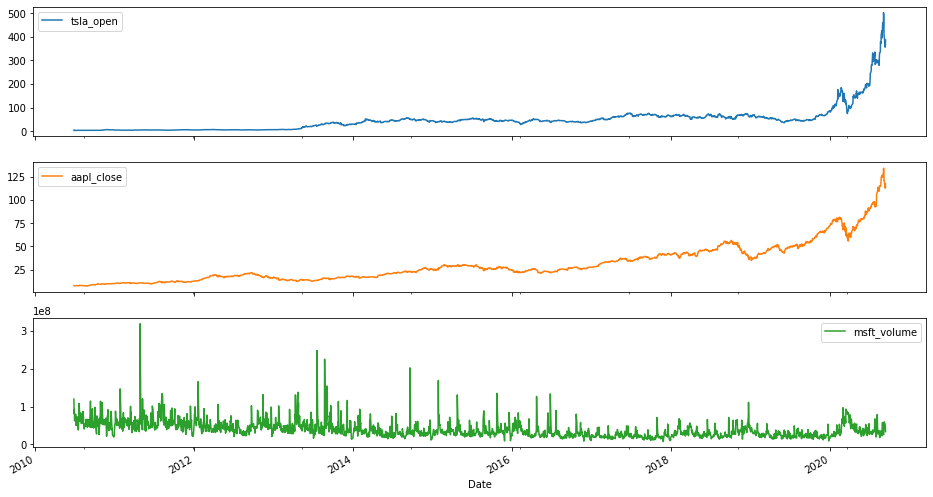

In [29]:
final_flattened_df[['tsla_open', 'aapl_close', 'msft_volume']].plot(subplots=True)

In [30]:
df = final_flattened_df.copy()

### Feature Engineering

#### Time

We want to account for seasonality in prices. We can map our `date` index feature datetimes into useable signals using sin and cos.

In [31]:
index_timestamp_seconds = np.array(df.index.map(datetime.datetime.timestamp))
index_timestamp_seconds

array([1.2777840e+09, 1.2778704e+09, 1.2779568e+09, ..., 1.5995376e+09,
       1.5996240e+09, 1.5997104e+09])

In [32]:
seconds_per_day = 24 * 60 * 60
seconds_per_year = 365.2425 * seconds_per_day
date_to_year_sin = np.sin(index_timestamp_seconds * (2 * np.pi / seconds_per_year))
date_to_year_cos = np.cos(index_timestamp_seconds * (2 * np.pi / seconds_per_year))

Text(0.5, 1.0, 'Time of year signal')

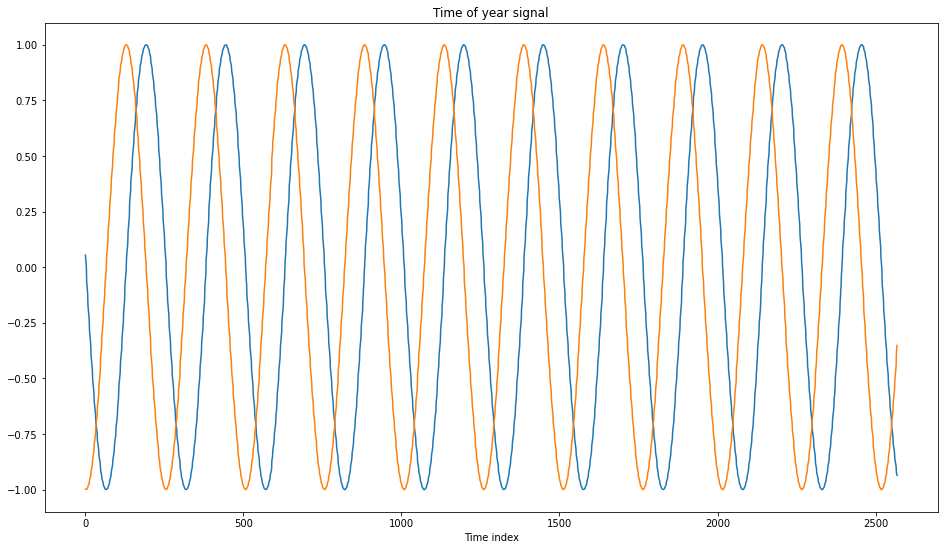

In [33]:
plt.plot(np.array(date_to_year_sin))
plt.plot(np.array(date_to_year_cos))
plt.xlabel('Time index')
plt.title('Time of year signal')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x153ff9730>,
      dtype=object)

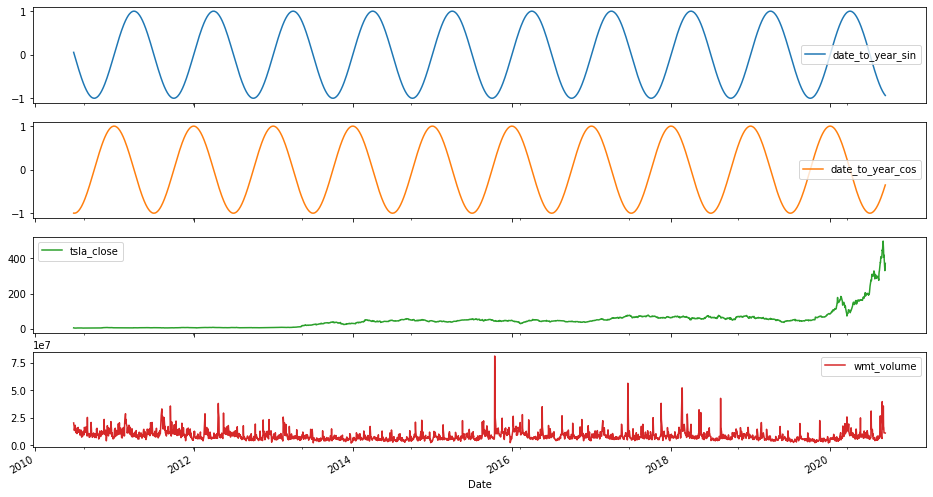

In [34]:
df['date_to_year_sin'] = date_to_year_sin
df['date_to_year_cos'] = date_to_year_cos
df[['date_to_year_sin', 'date_to_year_cos', 'tsla_close', 'wmt_volume']].plot(subplots=True)

### Split the data

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [35]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that we get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [36]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

We can use a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) to visualize the probability density of the data at different values. Using a [seaborn violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html).

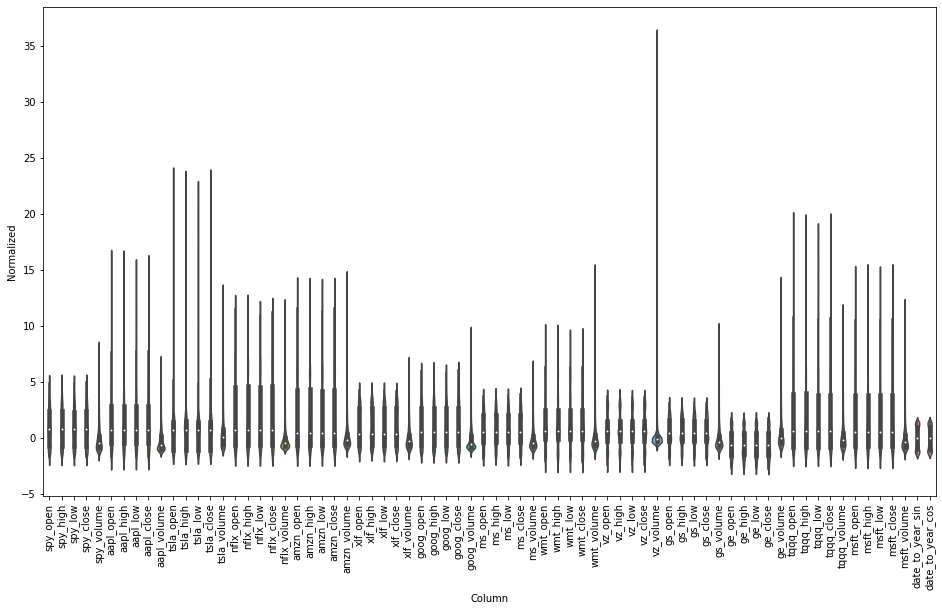

In [37]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure()
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.

In [38]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='tsla_close', max_subplots=3):
        inputs, labels = self.example
        plt.figure()
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [date]')
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

### Single step models



In [39]:
label_columns = ['tsla_close']

In [40]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=label_columns)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['tsla_close']

In [41]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 72)
Labels shape (batch, time, features): (32, 1, 1)


#### baseline model

Need something simple to compare more complex models against

In [42]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [43]:
baseline = Baseline(label_index=column_indices[label_columns[0]])
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

17/17 [==============================] - 0s 827us/step - loss: 0.0088 - mean_absolute_error: 0.0660


In [44]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1,
    label_columns=label_columns)

wide_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['tsla_close']

In [45]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 72)
Output shape: (32, 1, 1)


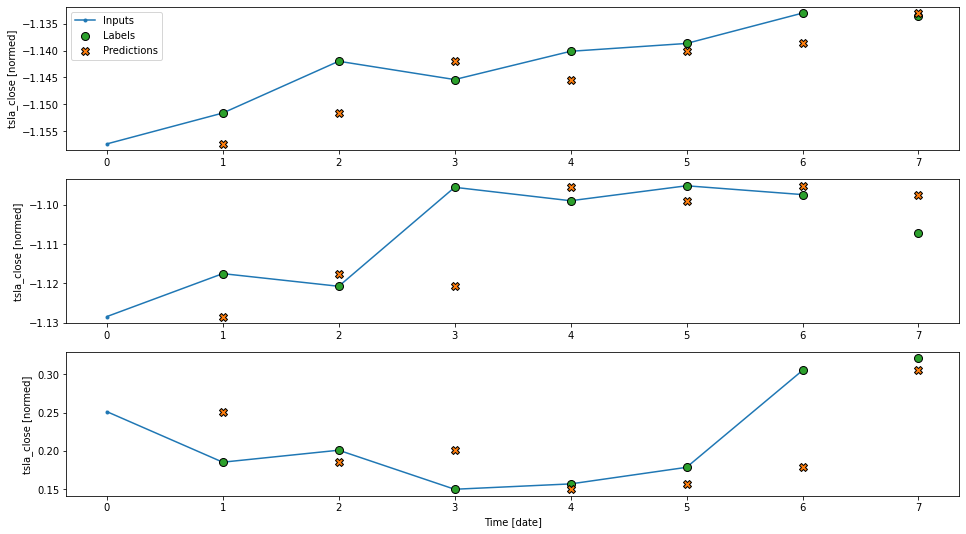

In [46]:
wide_window.plot(baseline)

In [47]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [48]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 72)
Output shape: (32, 1, 1)


In [49]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [50]:
%%time
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
57/57 [==============================] - 0s 3ms/step - loss: 1.7526 - mean_absolute_error: 1.0374 - val_loss: 1.0211 - val_mean_absolute_error: 0.8626
Epoch 2/50
57/57 [==============================] - 0s 2ms/step - loss: 0.6923 - mean_absolute_error: 0.6444 - val_loss: 0.9056 - val_mean_absolute_error: 0.7410
Epoch 3/50
57/57 [==============================] - 0s 2ms/step - loss: 0.3444 - mean_absolute_error: 0.4293 - val_loss: 1.3970 - val_mean_absolute_error: 0.9844
Epoch 4/50
17/17 [==============================] - 0s 1ms/step - loss: 1.6969 - mean_absolute_error: 1.1418
CPU times: user 2.06 s, sys: 549 ms, total: 2.61 s
Wall time: 1.1 s


In [51]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 7, 72)
Output shape: (32, 7, 1)


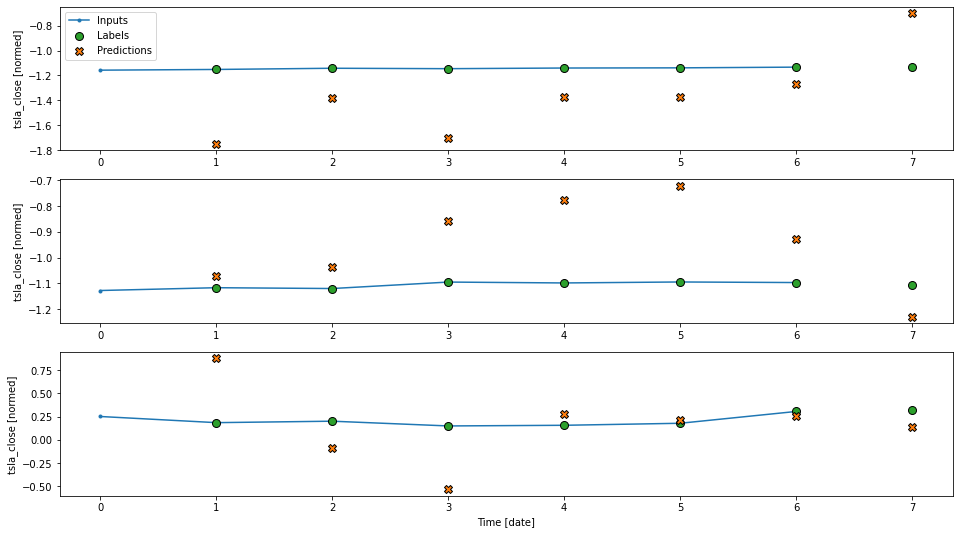

In [52]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to interpret. You can pull out the layer's weights, and see the weight assigned to each input:

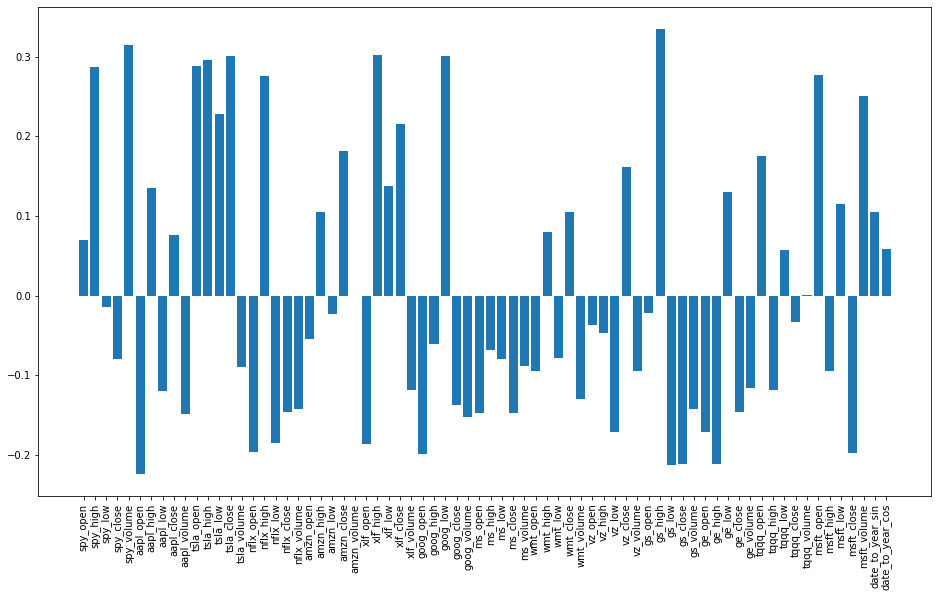

In [53]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `tsla_close`. This is one of the risks of random initialization.

### Dense

In [54]:
%%time
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

Epoch 1/50
57/57 [==============================] - 0s 4ms/step - loss: 0.1697 - mean_absolute_error: 0.2753 - val_loss: 1.6662 - val_mean_absolute_error: 1.1461
Epoch 2/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0184 - mean_absolute_error: 0.1039 - val_loss: 1.5627 - val_mean_absolute_error: 1.1181
Epoch 3/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0115 - mean_absolute_error: 0.0821 - val_loss: 1.2522 - val_mean_absolute_error: 0.9959
Epoch 4/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0084 - mean_absolute_error: 0.0701 - val_loss: 0.9732 - val_mean_absolute_error: 0.8678
Epoch 5/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0672 - val_loss: 0.7280 - val_mean_absolute_error: 0.7330
Epoch 6/50
57/57 [==============================] - 0s 2ms/step - loss: 0.0084 - mean_absolute_error: 0.0654 - val_loss: 0.8412 - val_mean_absolute_error: 0.8085
Epoch 7/50
57/57 [==========

#### Multi-step dense

In [55]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=label_columns)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['tsla_close']

Text(0.5, 1.0, 'Given 3 days as input, predict 1 day into the future.')

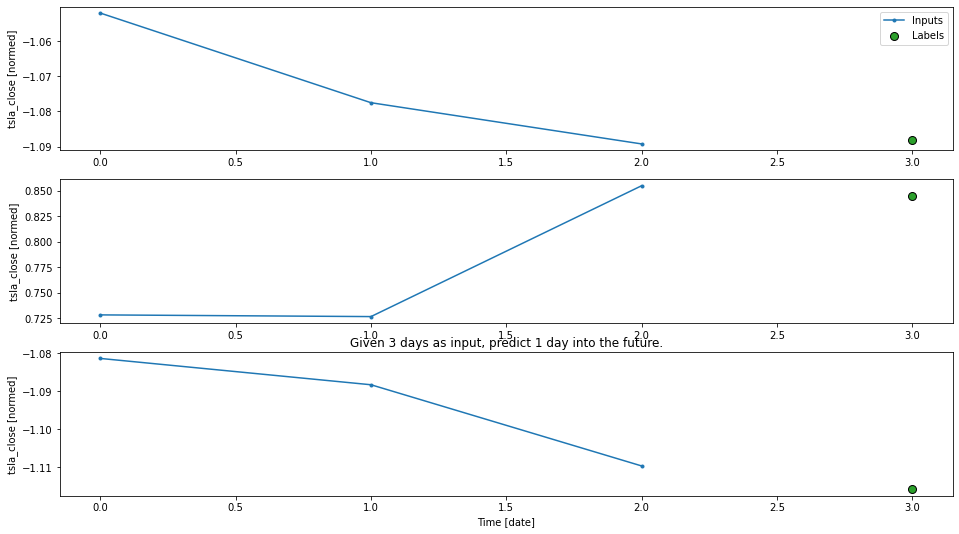

In [56]:
conv_window.plot()
plt.title("Given 3 days as input, predict 1 day into the future.")

You could train a dense model on a multiple-input-step window by adding a layers.Flatten as the first layer of the model

In [57]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [58]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 72)
Output shape: (32, 1, 1)


In [59]:
%%time
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test)

8/8 [==============================] - 0s 534us/step - loss: 2.3428 - mean_absolute_error: 1.3530
CPU times: user 5.91 s, sys: 1.91 s, total: 7.82 s
Wall time: 2.77 s


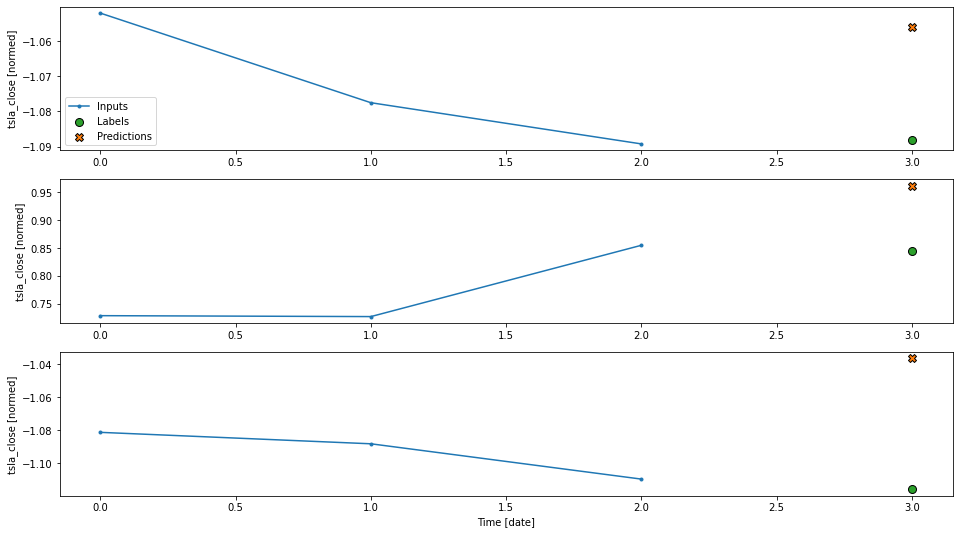

In [60]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input wndows of exactly this shape.

In [61]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 7, 72)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,504], In[1]: [216,32] [Op:MatMul]


### Convolution neural network

In [62]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [63]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 72)
Output shape: (32, 1, 1)


In [64]:
%%time
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

16/16 [==============================] - 0s 1ms/step - loss: 0.5407 - mean_absolute_error: 0.6462
CPU times: user 2.7 s, sys: 743 ms, total: 3.44 s
Wall time: 1.48 s


In [65]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 7, 72)
Labels shape: (32, 7, 1)
Output shape: (32, 5, 1)


In [66]:
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=label_columns)

wide_conv_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8]
Label indices: [3 4 5 6 7 8 9]
Label column name(s): ['tsla_close']

In [67]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 9, 72)
Labels shape: (32, 7, 1)
Output shape: (32, 7, 1)


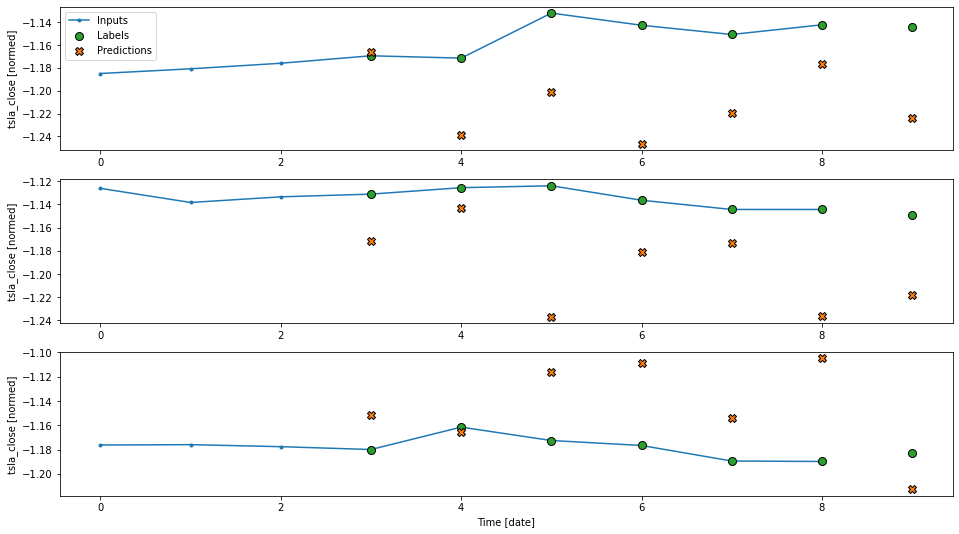

In [68]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

In [69]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [70]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 7, 72)
Output shape: (32, 7, 1)


In [71]:
%%time
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test)

8/8 [==============================] - 0s 912us/step - loss: 37.8981 - mean_absolute_error: 4.2275
CPU times: user 4.96 s, sys: 1.16 s, total: 6.11 s
Wall time: 3.22 s


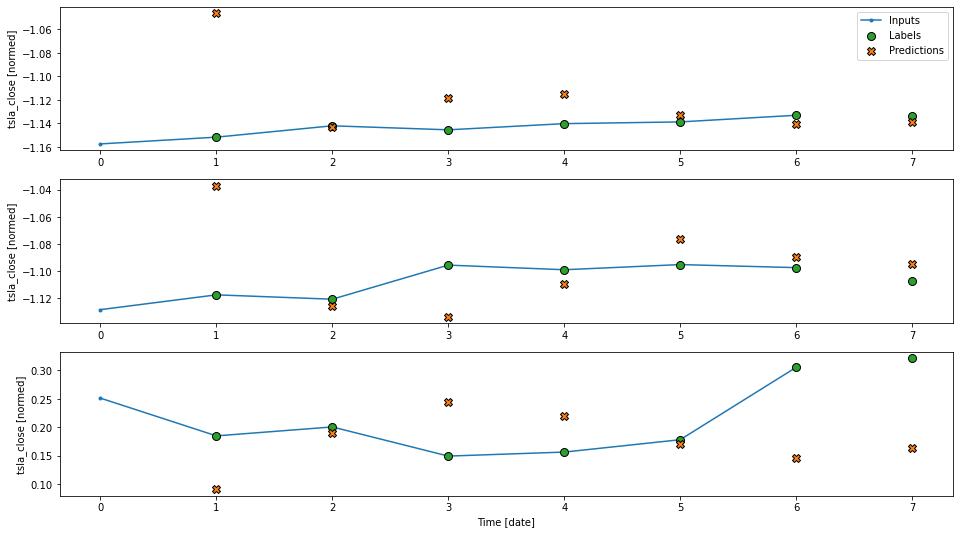

In [72]:
wide_window.plot(lstm_model)

### Performance

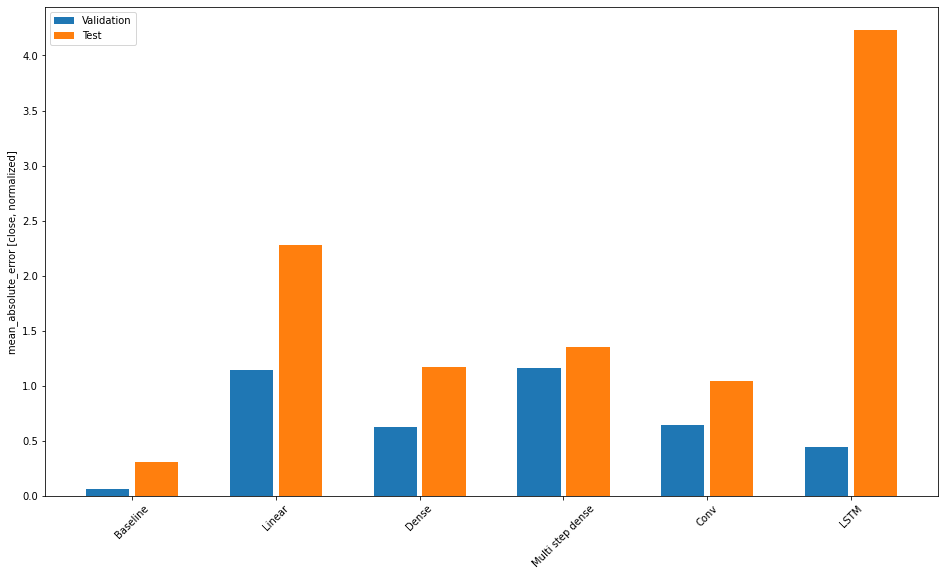

In [73]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [74]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.3083
Linear      : 2.2804
Dense       : 1.1770
Multi step dense: 1.3530
Conv        : 1.0460
LSTM        : 4.2275


### Multi Output Models

In [75]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 7, 72)
Labels shape (batch, time, features): (32, 7, 72)


In [76]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [77]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

16/16 [==============================] - 0s 1ms/step - loss: 0.1037 - mean_absolute_error: 0.1292


In [78]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [79]:
%%time
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test)

8/8 [==============================] - 0s 566us/step - loss: 4.8032 - mean_absolute_error: 1.7273
CPU times: user 5.04 s, sys: 1.62 s, total: 6.65 s
Wall time: 2.35 s


In [80]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

In [81]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

In [82]:
%%time
history = compile_and_fit(lstm_model, wide_window)
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)


16/16 [==============================] - 0s 2ms/step - loss: 2.6432 - mean_absolute_error: 1.2107
CPU times: user 17.7 s, sys: 5.38 s, total: 23.1 s
Wall time: 8.78 s


In [83]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [84]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

16/16 [==============================] - 0s 1ms/step - loss: 0.1017 - mean_absolute_error: 0.1318

CPU times: user 7.39 s, sys: 1.98 s, total: 9.37 s
Wall time: 4.16 s


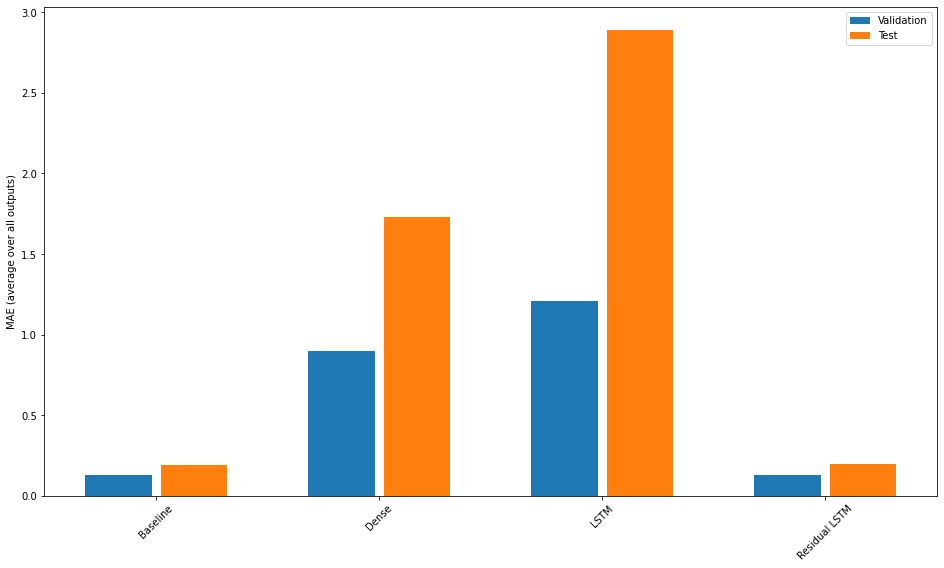

In [85]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

### Multi Step Models

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): None

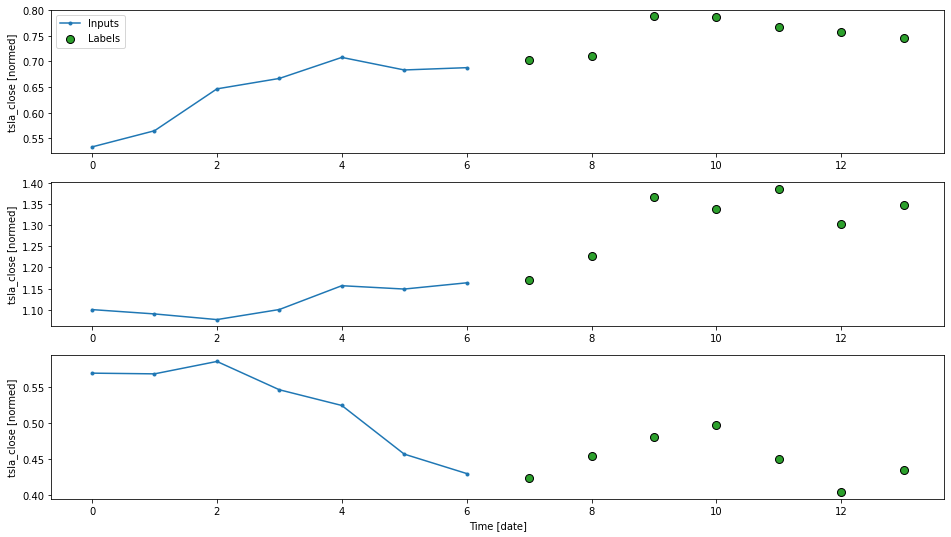

In [86]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

16/16 [==============================] - 0s 882us/step - loss: 0.1976 - mean_absolute_error: 0.2138


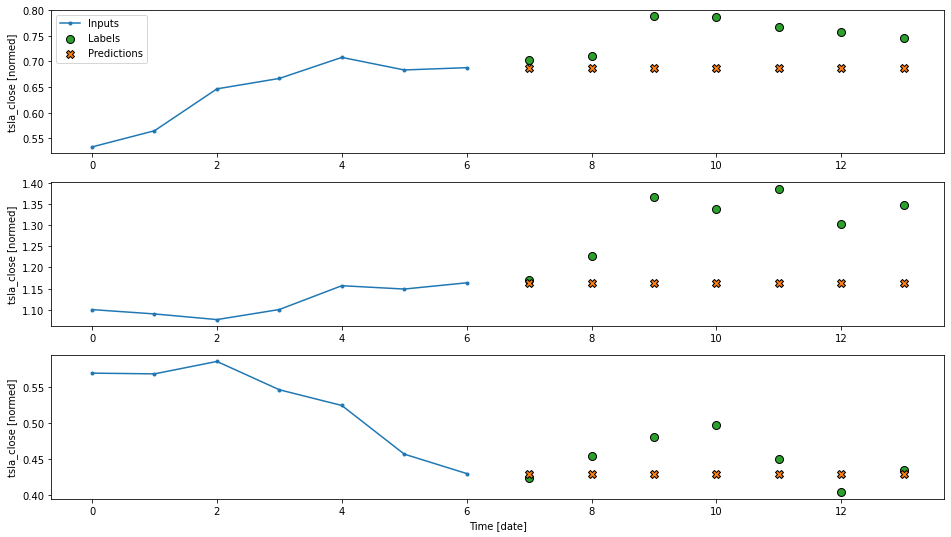

In [87]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

16/16 [==============================] - 0s 910us/step - loss: 0.2530 - mean_absolute_error: 0.2715


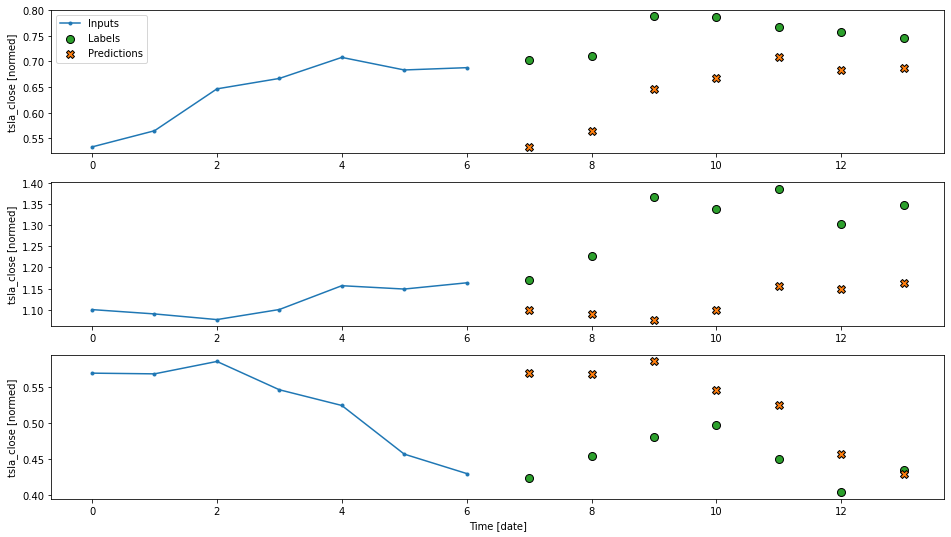

In [88]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

16/16 [==============================] - 0s 1ms/step - loss: 0.7176 - mean_absolute_error: 0.5821
CPU times: user 11.8 s, sys: 3.81 s, total: 15.6 s
Wall time: 5.15 s


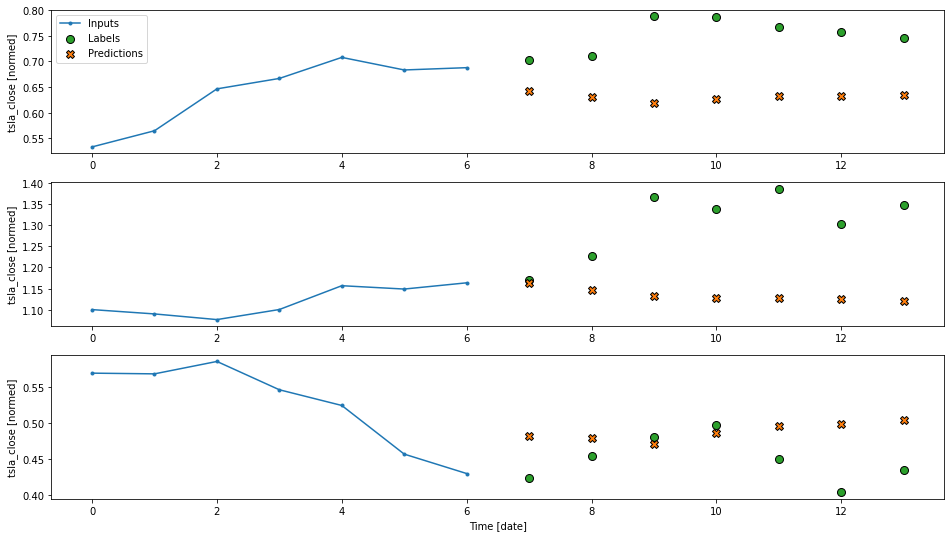

In [89]:
%%time
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)
IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x159d76f10>,
      dtype=object)

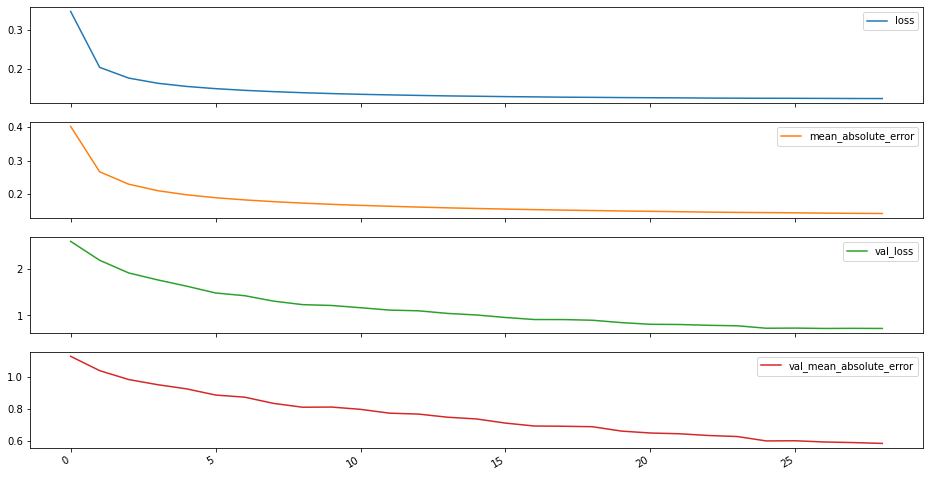

In [90]:
pd.DataFrame(history.history).plot(subplots=True)

### Dense
Adding a layers.Dense between the input and output gives the linear model more power, but is still only based on a single input timestep.

16/16 [==============================] - 0s 1ms/step - loss: 0.9019 - mean_absolute_error: 0.7086
CPU times: user 7.38 s, sys: 1.84 s, total: 9.22 s
Wall time: 3 s


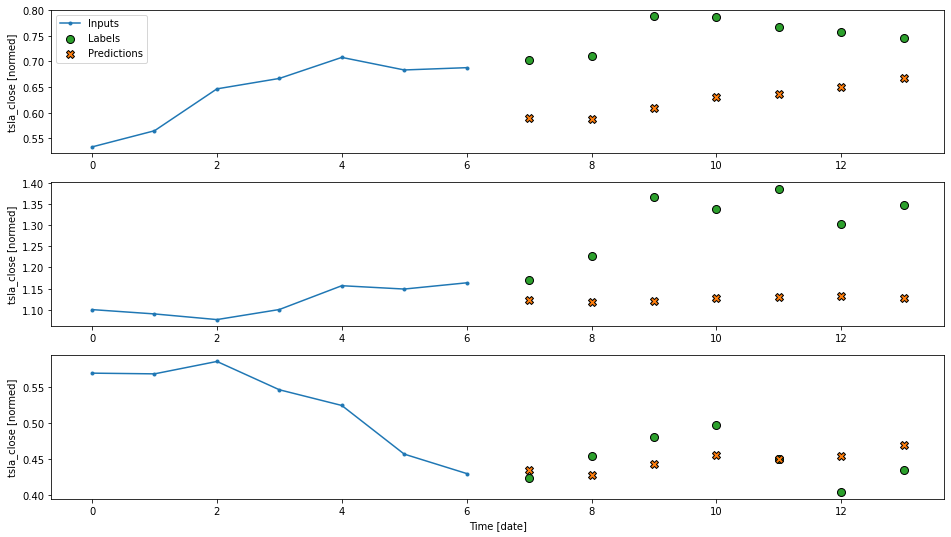

In [91]:
%%time
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1591c17f0>,
      dtype=object)

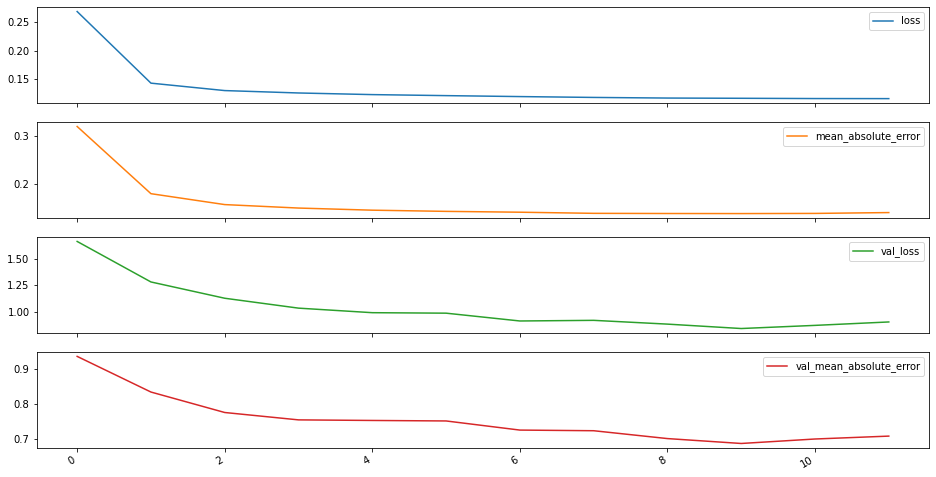

In [92]:
pd.DataFrame(history.history).plot(subplots=True)

### CNN

16/16 [==============================] - 0s 1ms/step - loss: 1.0644 - mean_absolute_error: 0.7918
CPU times: user 7.45 s, sys: 2.21 s, total: 9.66 s
Wall time: 3.23 s


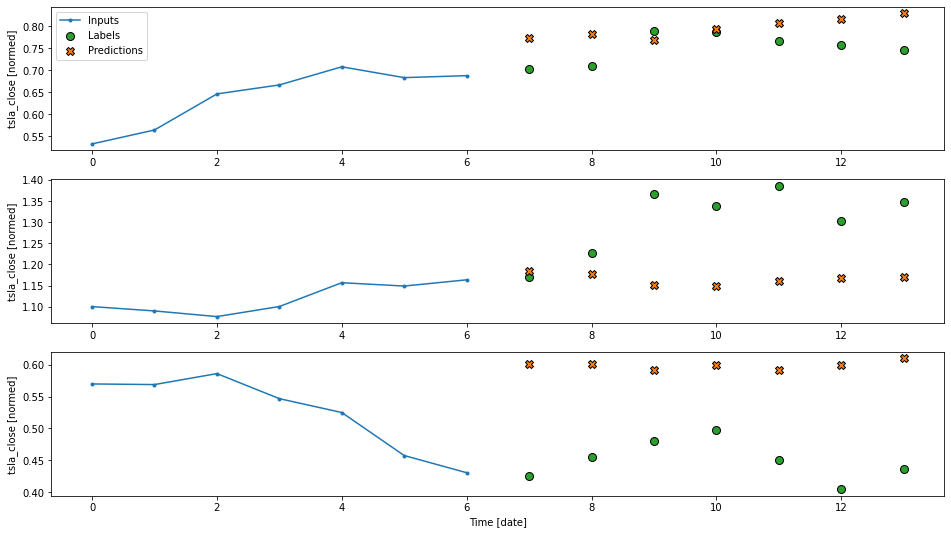

In [93]:
%%time
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x159cc7910>,
      dtype=object)

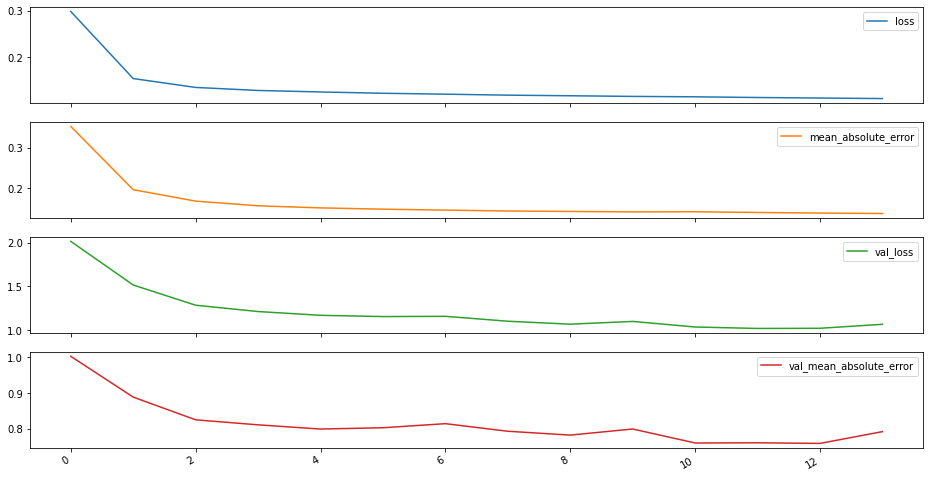

In [94]:
pd.DataFrame(history.history).plot(subplots=True)

### RNN

16/16 [==============================] - 0s 2ms/step - loss: 3.0801 - mean_absolute_error: 1.2788
CPU times: user 18.6 s, sys: 5.87 s, total: 24.5 s
Wall time: 9.15 s


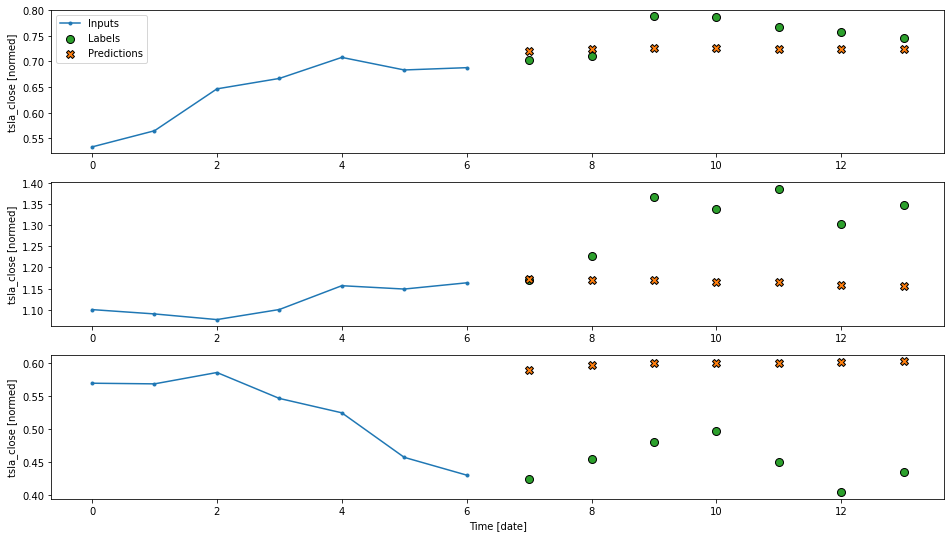

In [95]:
%%time
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15a7286d0>,
      dtype=object)

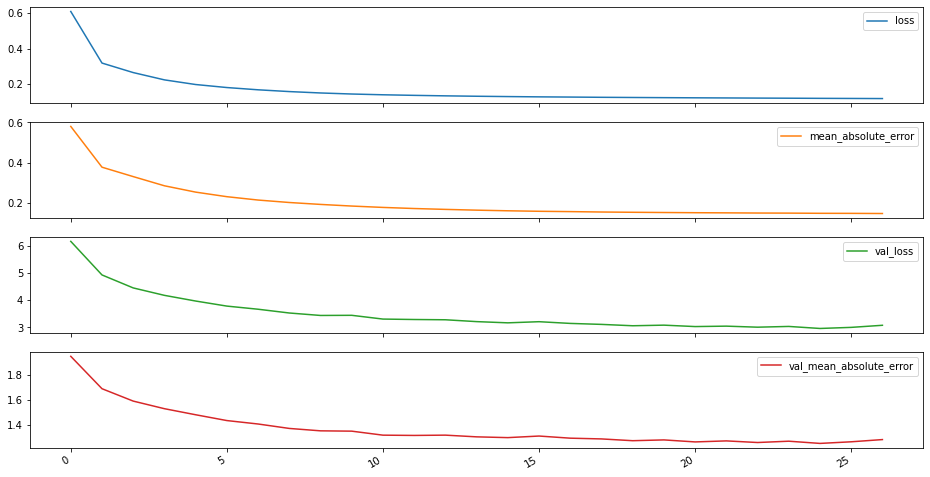

In [96]:
pd.DataFrame(history.history).plot(subplots=True)

### Advanced: Autoregressive model

#### RNN

In [97]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
   
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [98]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [99]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 72])

In [100]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 7, 72)


16/16 [==============================] - 0s 2ms/step - loss: 3.7137 - mean_absolute_error: 1.4493
CPU times: user 10.2 s, sys: 2.83 s, total: 13 s
Wall time: 5.35 s


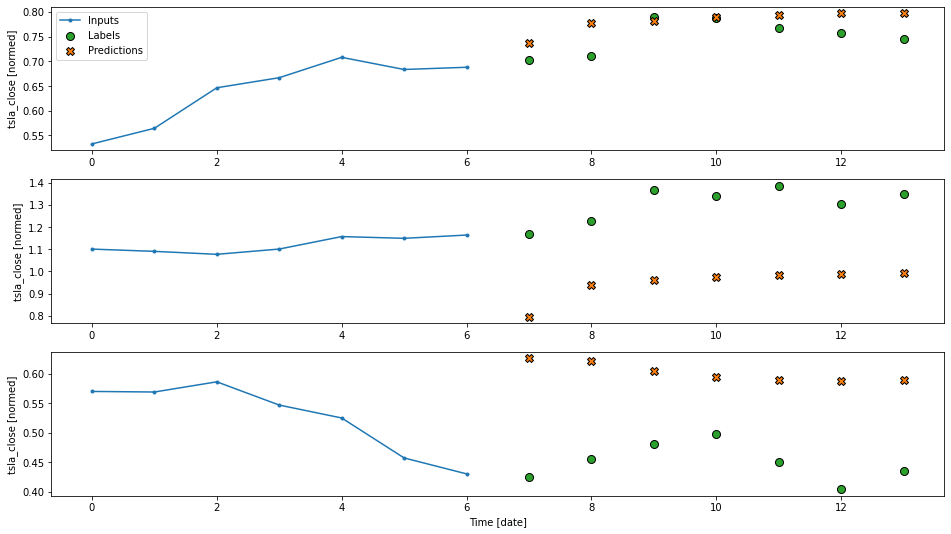

In [101]:
%%time
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15aad9a90>,
      dtype=object)

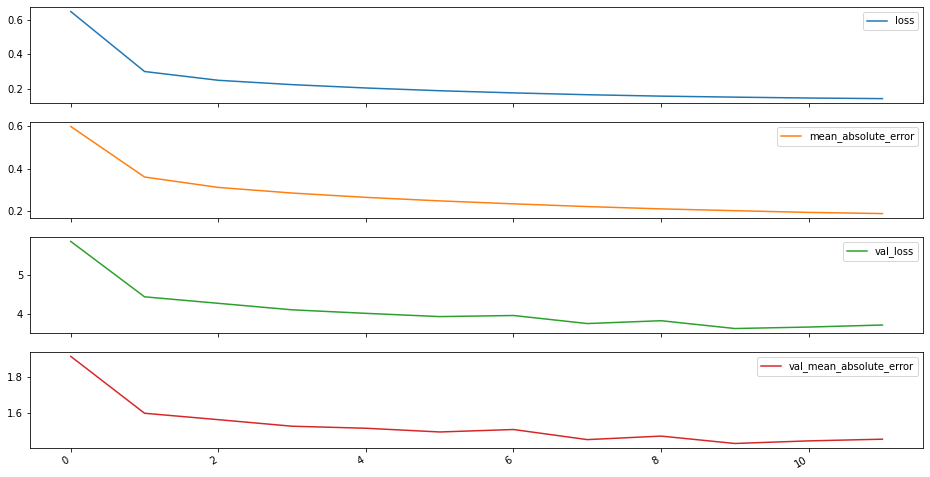

In [102]:
pd.DataFrame(history.history).plot(subplots=True)

### Reference Multi Step LSTM Models

[stacked-lstms-with-dropout](https://www.sciencedirect.com/science/article/pii/S1877050920304865)

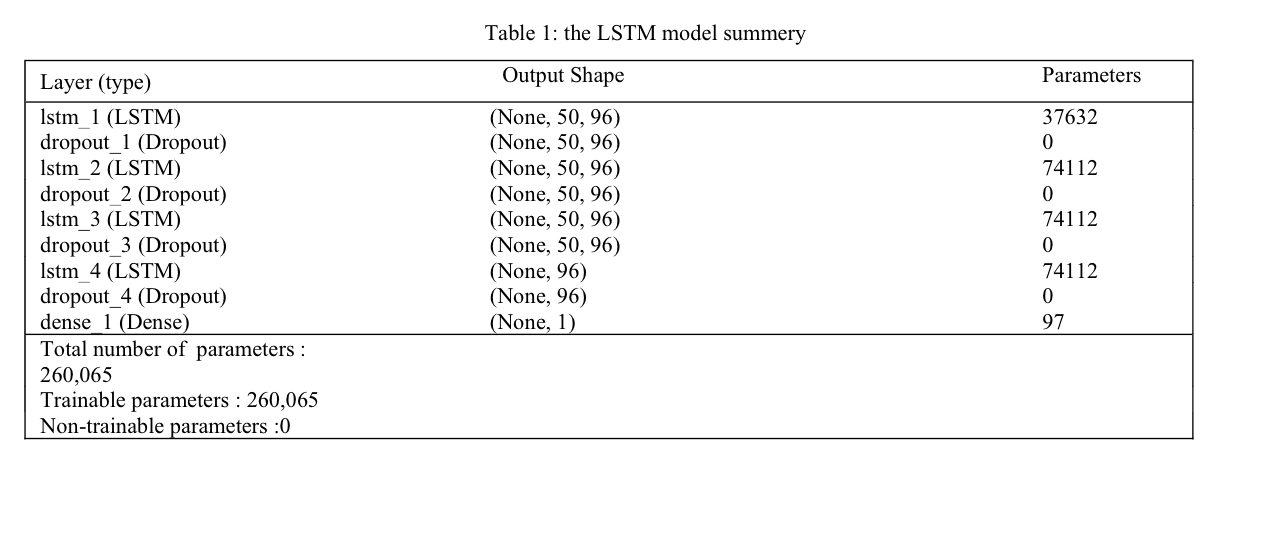

16/16 [==============================] - 0s 4ms/step - loss: 3.5006 - mean_absolute_error: 1.3713
CPU times: user 19.6 s, sys: 4.22 s, total: 23.8 s
Wall time: 11 s


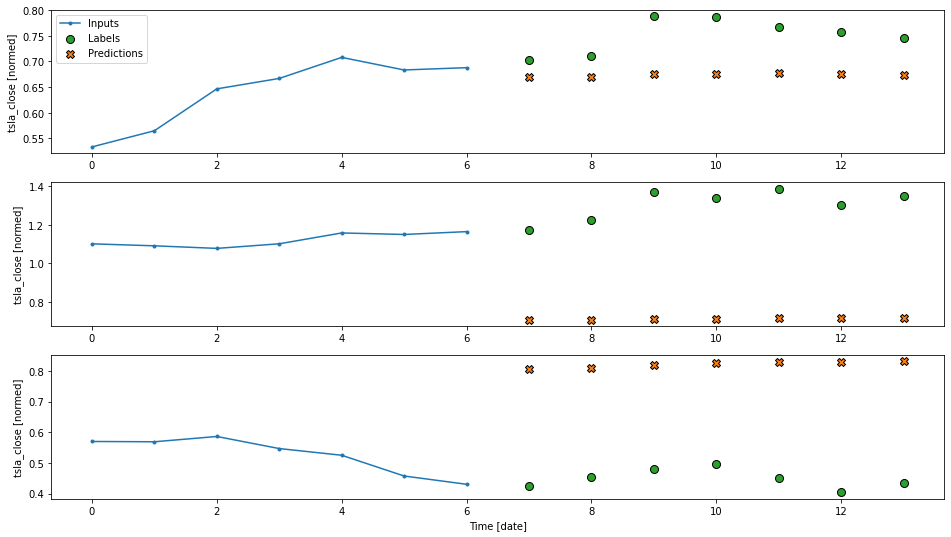

In [110]:
%%time
stacked_lstm_dropout_reference_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(96, return_sequences=True),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.LSTM(96),
    tf.keras.layers.Dropout(0.20),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(stacked_lstm_dropout_reference_model, multi_window)

IPython.display.clear_output()
multi_val_performance['stacked_lstm_dropout_reference_model'] = stacked_lstm_dropout_reference_model.evaluate(multi_window.val)
multi_performance['stacked_lstm_dropout_reference_model'] = stacked_lstm_dropout_reference_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(stacked_lstm_dropout_reference_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15d4b4550>,
      dtype=object)

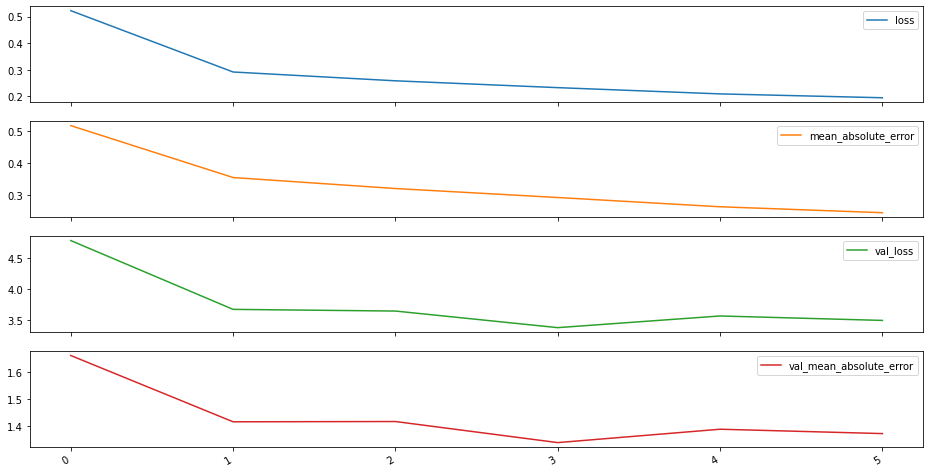

In [111]:
pd.DataFrame(history.history).plot(subplots=True)

### Custom Multi Step Models

Using a CNN with average pooling and dropout layer in front of stacked Bidirectional LSTM layers.

16/16 [==============================] - 0s 1ms/step - loss: 3.2148 - mean_absolute_error: 1.3149
CPU times: user 22.4 s, sys: 5.93 s, total: 28.3 s
Wall time: 11.5 s


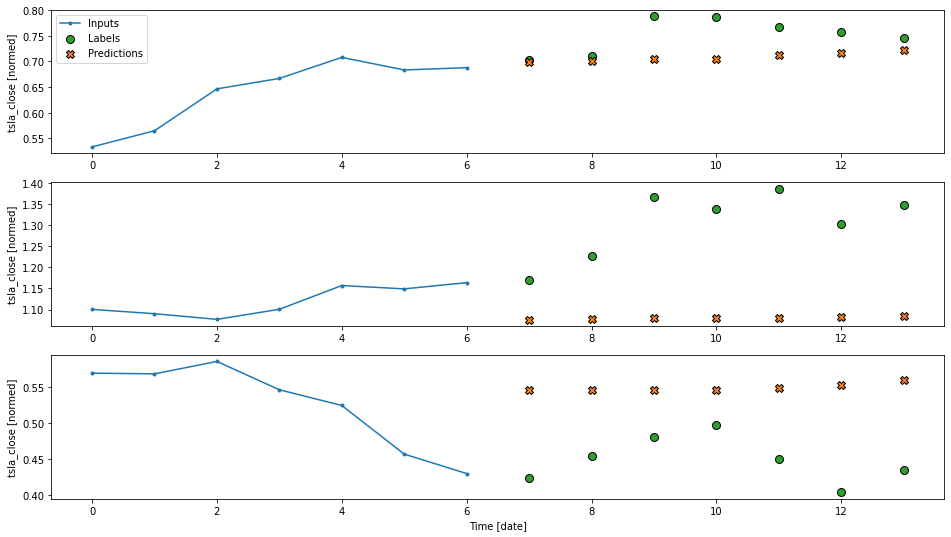

In [112]:
%%time
custom_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.AveragePooling1D(1),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.20),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(custom_model, multi_window)

IPython.display.clear_output()
multi_val_performance['custom_model'] = custom_model.evaluate(multi_window.val)
multi_performance['custom_model'] = custom_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(custom_model)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x15b495520>,
      dtype=object)

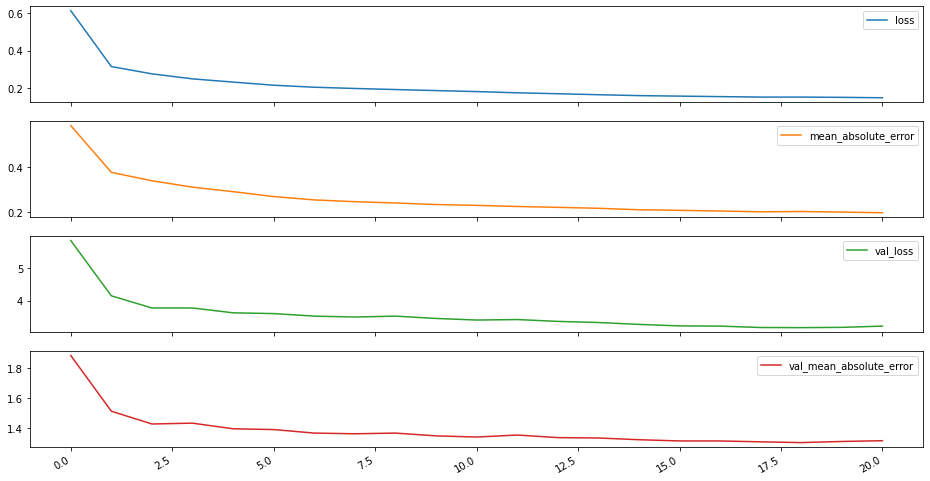

In [113]:
pd.DataFrame(history.history).plot(subplots=True)

### Performance

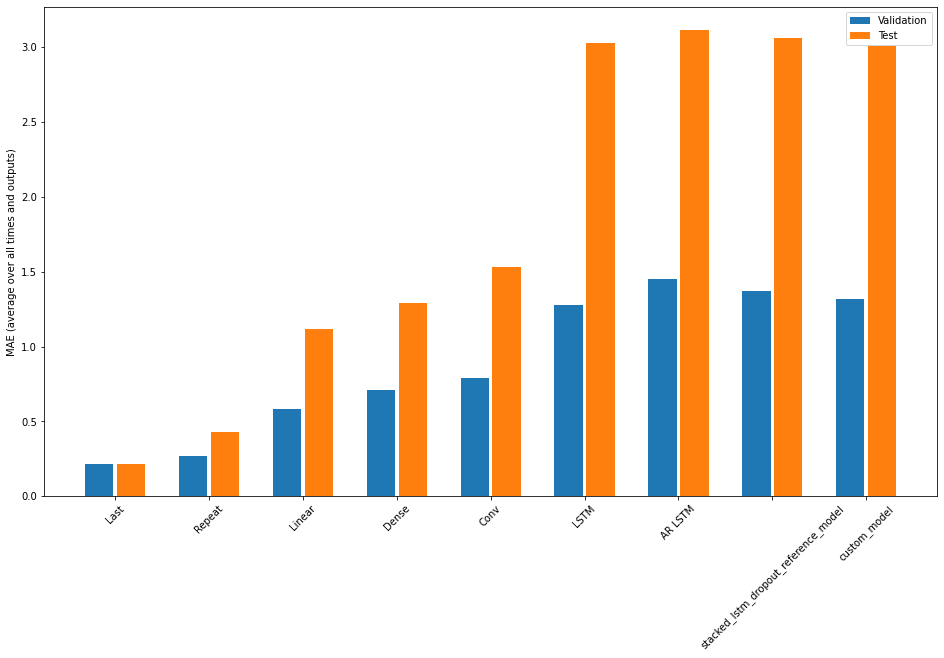

In [114]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [115]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.2138
Repeat  : 0.4307
Linear  : 1.1150
Dense   : 1.2879
Conv    : 1.5317
LSTM    : 3.0311
AR LSTM : 3.1130
stacked_lstm_dropout_reference_model: 3.0600
custom_model: 3.0055


Peeking at some other predictions made by the custom model... it predicts all features!

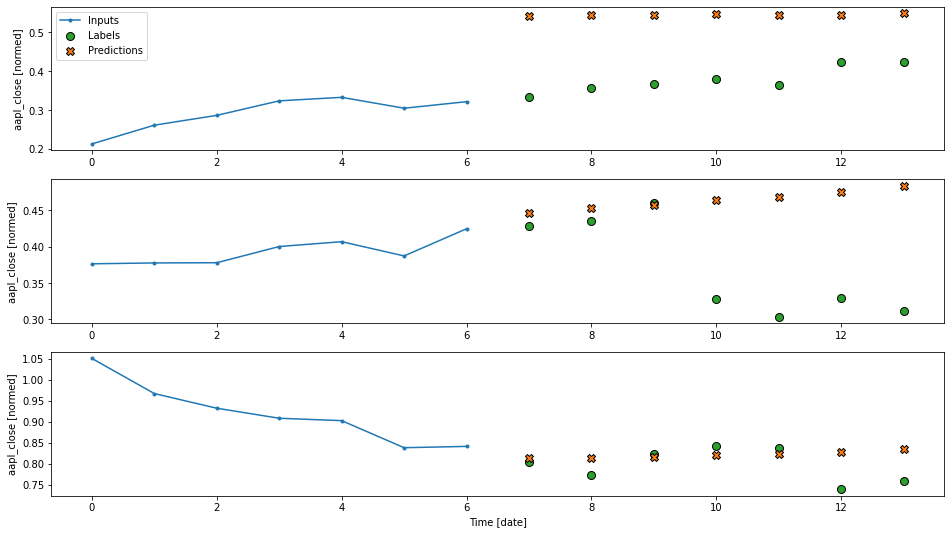

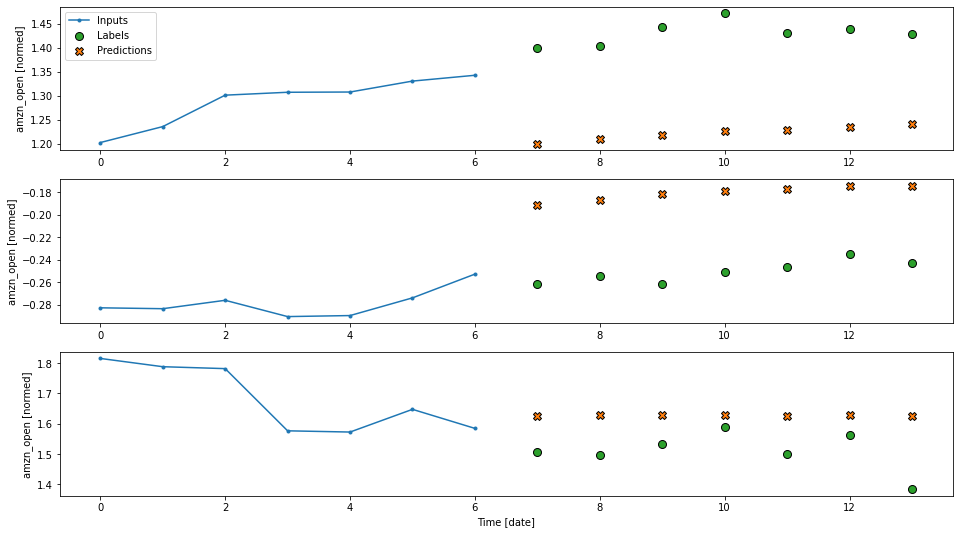

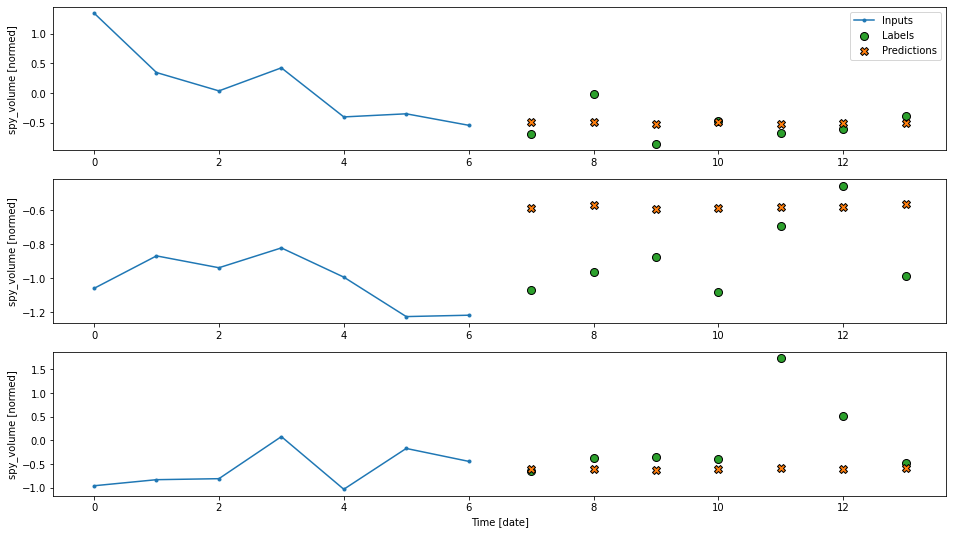

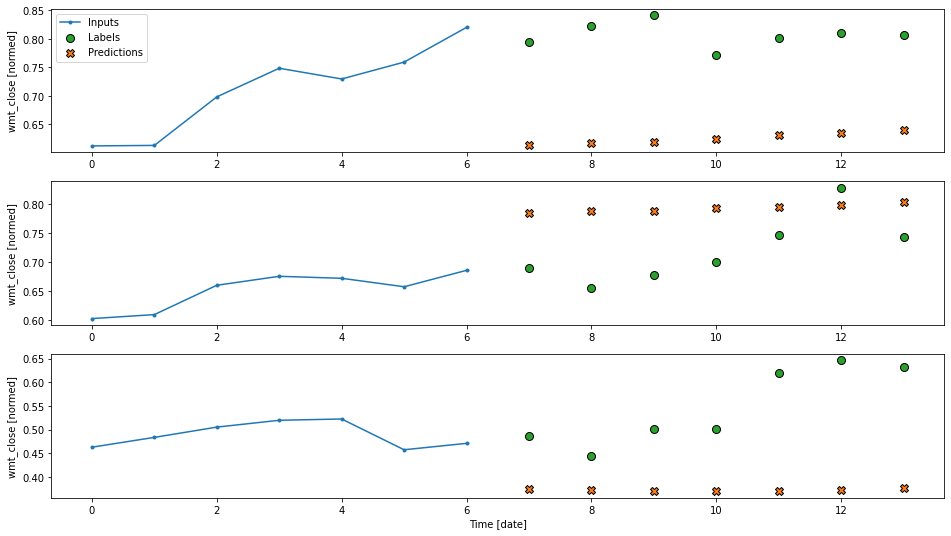

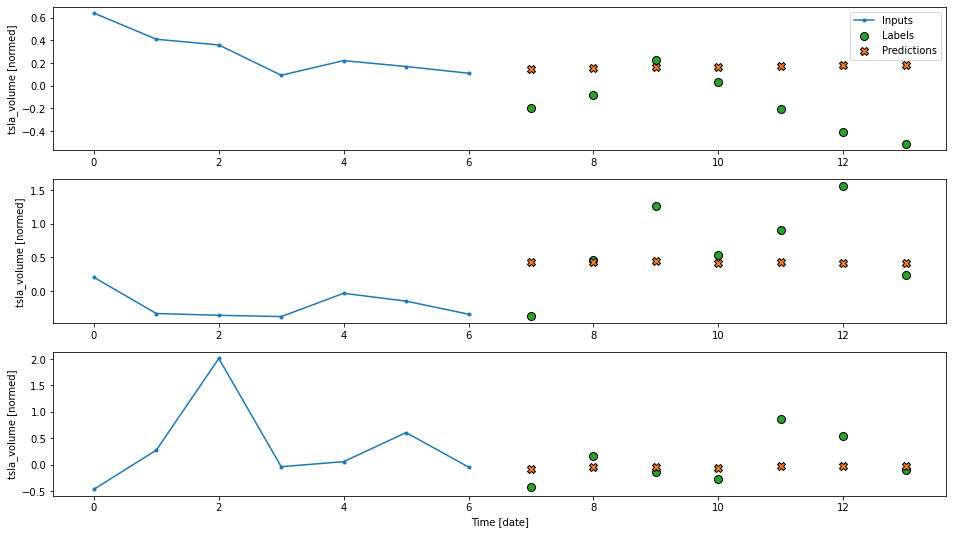

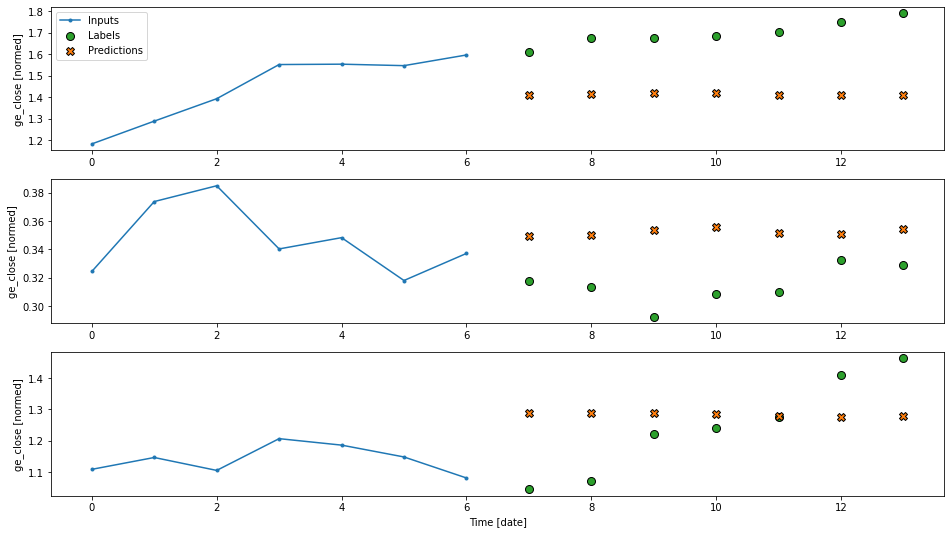

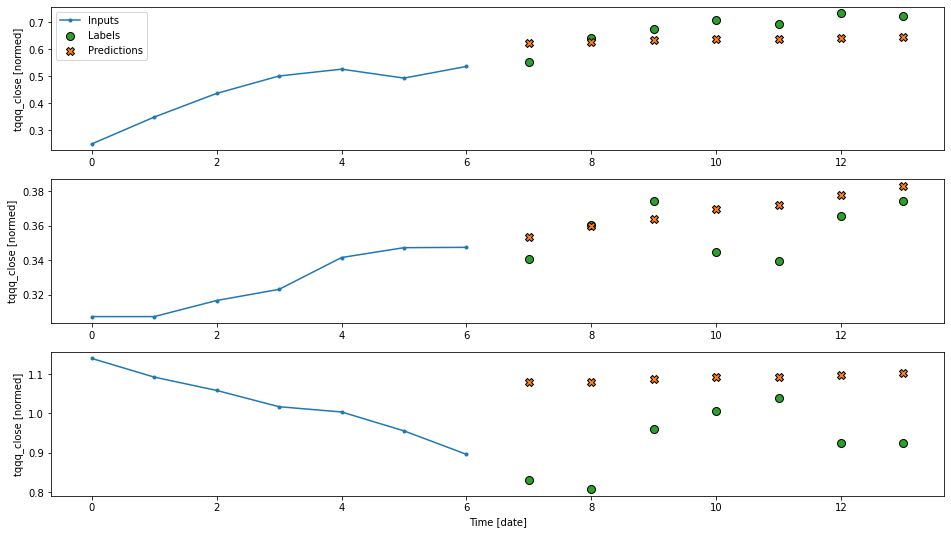

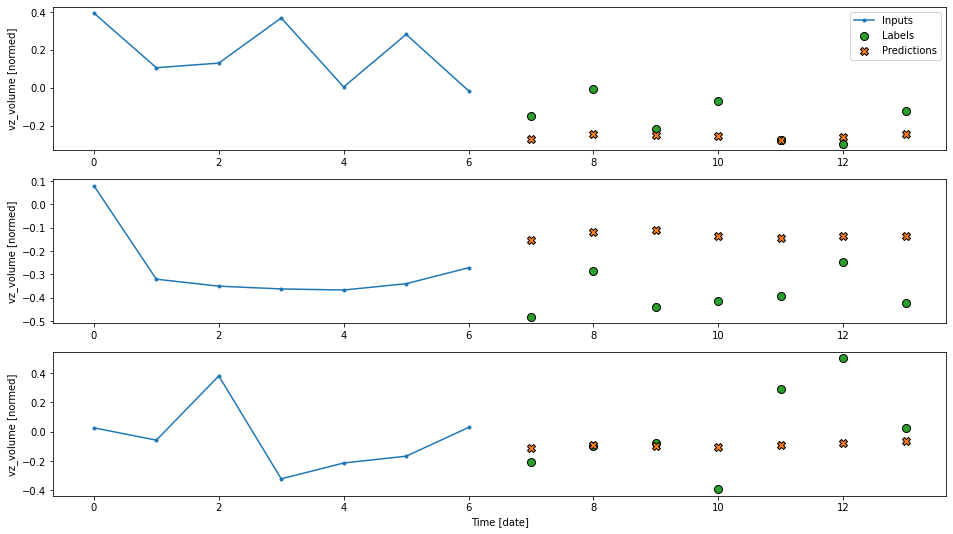

In [116]:
for plot_col in ['aapl_close', 'amzn_open', 'spy_volume', 'wmt_close', 'tsla_volume', 'ge_close', 'tqqq_close', 'vz_volume']:
    multi_window.plot(custom_model, plot_col)

Store the trained model weights

In [117]:
custom_model.save_weights('./checkpoints/custom-model')

### Making predictions with the saved model